# Image Upscaling sử dụng kỹ thuật CNN:

## Thiết lập môi trường:


### Cài đặt các công cụ cần thiết:

In [36]:
# Kết nối với Drive:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Clone repository từ Github:
%cd /content/gdrive/MyDrive
!git clone https://github.com/NHuy165/Group-Project---Image-Upscaling.git
%cd Group-Project---Image-Upscaling

In [ ]:
# Tải các thư viện cần thiết:
!pip install -r requirements.txt

### Cài đặt thư viện:

In [14]:
import os
import math
import PIL
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from keras.applications import vgg16
from tensorflow.keras.preprocessing.image import load_img, array_to_img, img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from IPython.display import display

## Thu thập và xử lý dữ liệu:

### Thu thập dữ liệu:

In [15]:
url = "https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz"
# Dữ liệu gồm 500 hình ảnh.

data_path = tf.keras.utils.get_file(origin=url, untar=True, fname="BSR")
root_path = os.path.join(data_path, "BSDS500/data")



70763455/70763455 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


### Phân loại dữ liệu:

In [16]:
# Quy định về kích thước ảnh đầu ra mặc định (target_size) là 300x300 và ảnh đầu vào luôn được giảm xuống kích thước mặc định là 100x100. batch_size được quy định là 8.
target_size = 300
upscale_factor = 3
input_size = target_size // upscale_factor
batch_size = 8

# Phân loại dữ liệu thành dữ liệu huấn luyện (training dataset) và dữ liệu kiểm tra (validation dataset), đồng thời chuẩn hóa kích thước thành 300x300.
train_data_raw = tf.keras.preprocessing.image_dataset_from_directory(
    root_path,
    batch_size = batch_size,
    label_mode=None,
    image_size=(target_size, target_size),
    validation_split=0.2,
    subset="training",
    seed=1337
)

validate_data_raw = tf.keras.preprocessing.image_dataset_from_directory(
    root_path,
    batch_size = batch_size,
    label_mode=None,
    image_size=(target_size, target_size),
    validation_split=0.2,
    subset="validation",
    seed=1337
)

Found 500 files.
Using 400 files for training.
Found 500 files.
Using 100 files for validation.


### Xử lý dữ liệu:

#### Chuẩn hóa pixel:

In [17]:
# Chuẩn hóa giá trị pixel của mỗi ảnh từ [0, 255] về [0, 1].
def scale(img):
    return (img)/255.0

train_data = train_data_raw.map(scale)
validate_data = validate_data_raw.map(scale)

#### Tiền xử lý chi tiết:

In [18]:
# process_input chuyển đổi ảnh sang không gian màu YUV và tách kênh màu Y, sau đó chỉnh lại kích cỡ ảnh.
def process_input(img, new_size, upscale_factor):
    img = tf.image.rgb_to_yuv(img)
    y = tf.split(img, 3, axis = len(img.shape)-1)[0]
    return tf.image.resize(y, [new_size, new_size], method="area")


def process_target(img):
    img = tf.image.rgb_to_yuv(img) # Change the image format to yuv scale,
    y = tf.split(img, 3, axis=len(img.shape)-1)[0]
    return y

train_data_scaled = train_data.map(
    lambda img: (process_input(img, input_size, upscale_factor), process_target(img))
)

train_ds = train_data_scaled.prefetch(buffer_size=32)

validate_data_scaled = validate_data.map(
    lambda img: (process_input(img, input_size, upscale_factor), process_target(img))
)

valid_ds = validate_data_scaled.prefetch(buffer_size=32)


#### Hiển thị và kiểm tra:

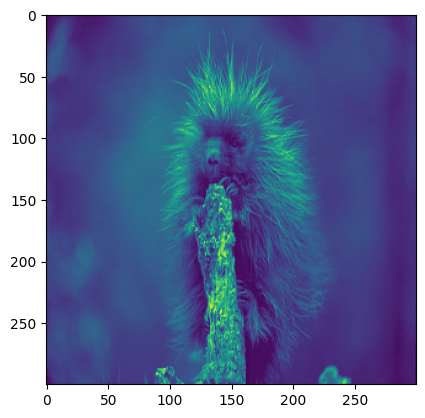

<Figure size 30000x30000 with 0 Axes>

(300, 300) 



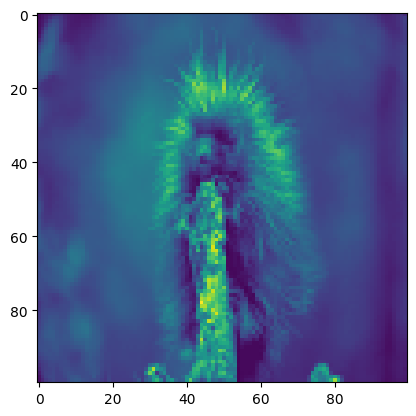

<Figure size 10000x10000 with 0 Axes>

(100, 100)


In [19]:
l = list(train_ds)

img1 = tf.keras.preprocessing.image.array_to_img(l[0][1][0])
plt.imshow(img1)
plt.figure(figsize=(img1.size[0], img1.size[1]))
plt.show()
print(img1.size,"\n")

img2 = tf.keras.preprocessing.image.array_to_img(l[0][0][0])
plt.imshow(img2)
plt.figure(figsize=(img2.size[0], img2.size[1]))
plt.show()
print(img2.size)

## Xây dựng và huấn luyện mô hình:

### Xây dựng mô hình cơ sở:

#### Xây dựng lớp DepthToSpaceLayer:

In [20]:
# Lớp tùy chỉnh trong Keras có nhiệm vụ tái tổ chức không gian:
from tensorflow.keras.layers import Layer
import tensorflow as tf

class DepthToSpaceLayer(Layer):
    def __init__(self, block_size, **kwargs):
        super(DepthToSpaceLayer, self).__init__(**kwargs)
        self.block_size = block_size

    def call(self, inputs):
        return tf.nn.depth_to_space(inputs, block_size=self.block_size)

    def get_config(self):
        config = super(DepthToSpaceLayer, self).get_config()
        config.update({"block_size": self.block_size})
        return config

#### Xây dựng hàm tạo mô hình:

In [21]:
def get_model(upscale_factor=3, channels=1):
    conv_args = {
        "activation": "relu",
        "kernel_initializer": "Orthogonal",
        "padding": "same",
    }
    inputs = keras.Input(shape=(None, None, channels))
    x = layers.Conv2D(64, 5, **conv_args)(inputs)
    x = layers.Conv2D(64, 3, **conv_args)(x)
    x = layers.Conv2D(32, 3, **conv_args)(x)
    x = layers.Conv2D(channels * (upscale_factor ** 2), 3, **conv_args)(x)
    outputs = DepthToSpaceLayer(upscale_factor)(x)

    return keras.Model(inputs, outputs)

### Xây dựng công cụ theo dõi và đánh giá quá trình huấn luyện:

#### Xây dựng các hàm cần thiết:

In [22]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import PIL


def plot_results(img, prefix, title):
    """Plot the result with zoom-in area."""
    img_array = img_to_array(img)
    img_array = img_array.astype("float32") / 255.0

    # Create a new figure with a default 111 subplot.
    fig, ax = plt.subplots()
    im = ax.imshow(img_array[::-1], origin="lower")

    plt.title(title)
    # zoom-factor: 2.0, location: upper-left
    axins = zoomed_inset_axes(ax, 2, loc=2)
    axins.imshow(img_array[::-1], origin="lower")

    # Specify the limits.
    x1, x2, y1, y2 = 200, 300, 100, 200
    # Apply the x-limits.
    axins.set_xlim(x1, x2)
    # Apply the y-limits.
    axins.set_ylim(y1, y2)

    plt.yticks(visible=False)
    plt.xticks(visible=False)

    # Make the line.
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="blue")
    plt.savefig(str(prefix) + "-" + title + ".png")
    plt.show()


def get_lowres_image(img, upscale_factor):
    """Return low-resolution image to use as model input."""
    return img.resize(
        (img.size[0] // upscale_factor, img.size[1] // upscale_factor),
        PIL.Image.BICUBIC,
    )


def upscale_image(model, img):
    """Predict the result based on input image and restore the image as RGB."""
    ycbcr = img.convert("YCbCr")
    y, cb, cr = ycbcr.split()
    y = img_to_array(y)
    y = y.astype("float32") / 255.0

    input = np.expand_dims(y, axis=0)
    out = model.predict(input)

    out_img_y = out[0]
    out_img_y *= 255.0

    # Restore the image in RGB color space.
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = out_img_y.reshape((np.shape(out_img_y)[0], np.shape(out_img_y)[1]))
    out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
    out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert(
        "RGB"
    )
    return out_img

#### Xây dựng các cơ chế kiểm soát quá trình huấn luyện:

In [23]:
dataset = os.path.join(root_path, "images")
test_path = os.path.join(dataset, "test")

test_img_paths = sorted(
    [
        os.path.join(test_path, fname)
        for fname in os.listdir(test_path)
        if fname.endswith(".jpg")
    ]
)

class ESPCNCallback(keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.test_img = get_lowres_image(load_img(test_img_paths[0]), upscale_factor)

    # Store PSNR value in each epoch.
    def on_epoch_begin(self, epoch, logs=None):
        self.psnr = []

    def on_test_batch_end(self, batch, logs=None):
        self.psnr.append(10 * math.log10(1 / logs["loss"]))

    def on_epoch_end(self, epoch, logs=None):
        print("Mean PSNR for epoch: %.2f" % (np.mean(self.psnr)))
        if epoch % 20 == 0:
            prediction = upscale_image(self.model, self.test_img)
            plot_results(prediction, "epoch-" + str(epoch), "prediction")

In [24]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10)

In [25]:
checkpoint_filepath = "/tmp/checkpoint.weights.h5"

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="loss",
    mode="min",
    save_best_only=True,
)

### Huấn luyện mô hình:

#### Tổng kết các công cụ cần thiết:

In [26]:
model = get_model(upscale_factor=upscale_factor, channels=1)
model.summary()

callbacks = [ESPCNCallback(), early_stopping_callback, model_checkpoint_callback]
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.001)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None, None, 1)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, None, None, 64)      │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, None, None, 32)      │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, None, None, 9)       │           2,601 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ depth_to_space_layer                 │ (None, None, None, 1)       │               0 │
│ (DepthToSpaceLayer)                  │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 59,657 (233.04 KB)

 Trainable params: 59,657 (233.04 KB)

 Non-trainable params: 0 (0.00 B)

#### Huấn luyện và lưu mô hình:

Epoch 1/150
Mean PSNR for epoch: 22.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


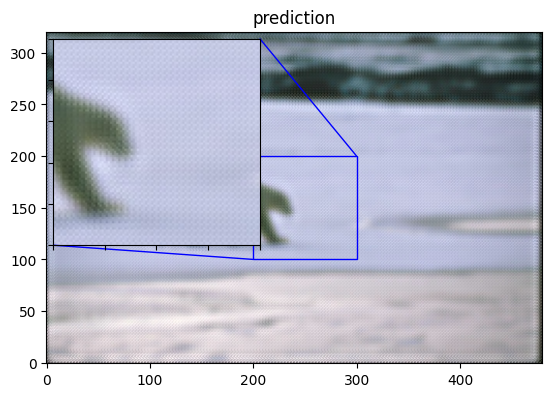

50/50 - 14s - 285ms/step - loss: 0.0332 - val_loss: 0.0058
Epoch 2/150
Mean PSNR for epoch: 24.96
50/50 - 10s - 195ms/step - loss: 0.0046 - val_loss: 0.0033
Epoch 3/150
Mean PSNR for epoch: 25.32
50/50 - 2s - 49ms/step - loss: 0.0034 - val_loss: 0.0028
Epoch 4/150
Mean PSNR for epoch: 25.59
50/50 - 2s - 31ms/step - loss: 0.0031 - val_loss: 0.0027
Epoch 5/150
Mean PSNR for epoch: 25.70
50/50 - 3s - 51ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 6/150
Mean PSNR for epoch: 26.16
50/50 - 3s - 68ms/step - loss: 0.0030 - val_loss: 0.0025
Epoch 7/150
Mean PSNR for epoch: 26.41
50/50 - 3s - 52ms/step - loss: 0.0029 - val_loss: 0.0025
Epoch 8/150
Mean PSNR for epoch: 26.57
50/50 - 2s - 31ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 9/150
Mean PSNR for epoch: 26.22
50/50 - 2s - 50ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 10/150
Mean PSNR for epoch: 26.23
50/50 - 1s - 29ms/step - loss: 0.0028 - val_loss: 0.0024
Epoch 11/150
Mean PSNR for epoch: 26.44
50/50 - 4s - 77ms/step - loss: 0.0

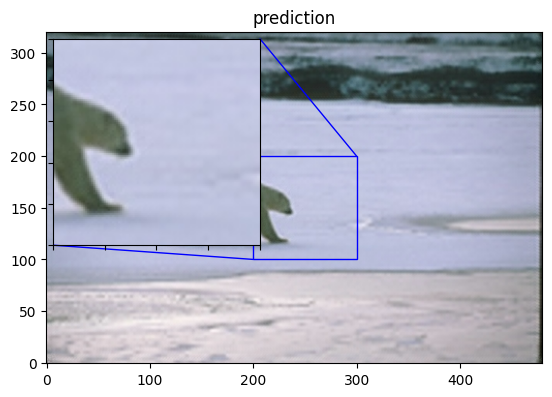

50/50 - 2s - 42ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 22/150
Mean PSNR for epoch: 25.45
50/50 - 2s - 30ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 23/150
Mean PSNR for epoch: 26.29
50/50 - 1s - 29ms/step - loss: 0.0030 - val_loss: 0.0026
Epoch 24/150
Mean PSNR for epoch: 26.22
50/50 - 3s - 52ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 25/150
Mean PSNR for epoch: 26.94
50/50 - 4s - 73ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 26/150
Mean PSNR for epoch: 26.47
50/50 - 4s - 84ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 27/150
Mean PSNR for epoch: 26.71
50/50 - 2s - 30ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 28/150
Mean PSNR for epoch: 26.60
50/50 - 2s - 32ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 29/150
Mean PSNR for epoch: 26.58
50/50 - 2s - 32ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 30/150
Mean PSNR for epoch: 26.66
50/50 - 3s - 60ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 31/150
Mean PSNR for epoch: 26.71
50/50 - 3s - 61ms/step - loss:

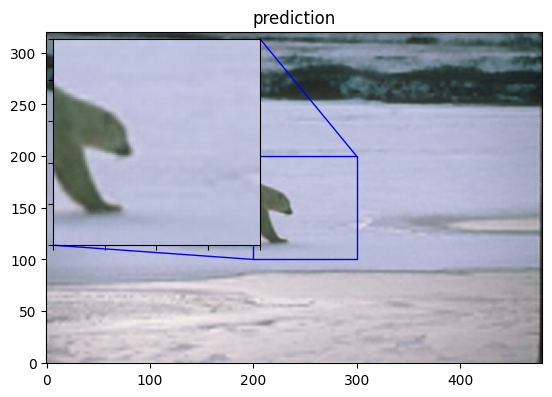

50/50 - 2s - 43ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 42/150
Mean PSNR for epoch: 26.70
50/50 - 3s - 51ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 43/150
Mean PSNR for epoch: 26.72
50/50 - 2s - 46ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 44/150
Mean PSNR for epoch: 26.34
50/50 - 2s - 30ms/step - loss: 0.0028 - val_loss: 0.0023
Epoch 45/150
Mean PSNR for epoch: 26.93
50/50 - 3s - 51ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 46/150
Mean PSNR for epoch: 26.78
50/50 - 2s - 31ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 47/150
Mean PSNR for epoch: 26.66
50/50 - 3s - 51ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 48/150
Mean PSNR for epoch: 26.84
50/50 - 1s - 30ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 49/150
Mean PSNR for epoch: 26.62
50/50 - 3s - 52ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 50/150
Mean PSNR for epoch: 27.19
50/50 - 2s - 47ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 51/150
Mean PSNR for epoch: 26.80
50/50 - 2s - 31ms/step - loss:

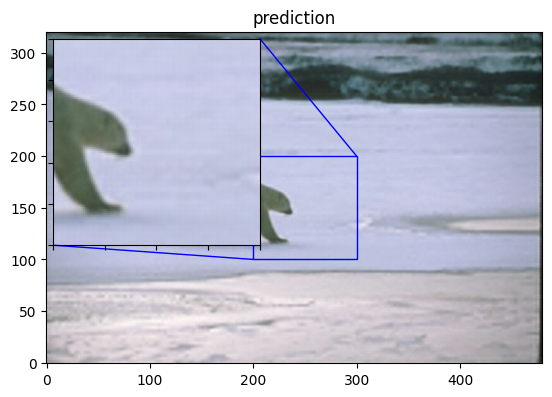

50/50 - 3s - 58ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 62/150
Mean PSNR for epoch: 26.25
50/50 - 4s - 78ms/step - loss: 0.0026 - val_loss: 0.0022
Epoch 63/150
Mean PSNR for epoch: 26.71
50/50 - 2s - 31ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 64/150
Mean PSNR for epoch: 26.64
50/50 - 3s - 52ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 65/150
Mean PSNR for epoch: 27.00
50/50 - 2s - 32ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 66/150
Mean PSNR for epoch: 27.06
50/50 - 2s - 39ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 67/150
Mean PSNR for epoch: 26.82
50/50 - 3s - 55ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 68/150
Mean PSNR for epoch: 26.47
50/50 - 2s - 40ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 69/150
Mean PSNR for epoch: 26.80
50/50 - 2s - 32ms/step - loss: 0.0026 - val_loss: 0.0022
Epoch 70/150
Mean PSNR for epoch: 26.82
50/50 - 2s - 48ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 71/150
Mean PSNR for epoch: 26.83
50/50 - 2s - 30ms/step - loss:

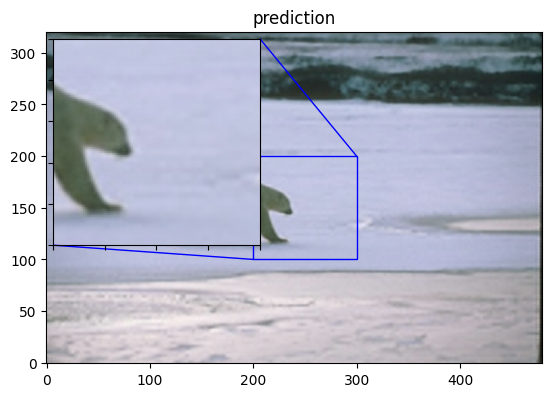

50/50 - 3s - 55ms/step - loss: 0.0026 - val_loss: 0.0022
Epoch 82/150
Mean PSNR for epoch: 26.54
50/50 - 3s - 53ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 83/150
Mean PSNR for epoch: 26.99
50/50 - 4s - 80ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 84/150
Mean PSNR for epoch: 26.79
50/50 - 3s - 50ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 85/150
Mean PSNR for epoch: 26.55
50/50 - 3s - 51ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 86/150
Mean PSNR for epoch: 26.95
50/50 - 2s - 38ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 87/150
Mean PSNR for epoch: 26.58
50/50 - 3s - 62ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 88/150
Mean PSNR for epoch: 26.97
50/50 - 2s - 30ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 89/150
Mean PSNR for epoch: 26.84
50/50 - 1s - 29ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 90/150
Mean PSNR for epoch: 26.55
50/50 - 3s - 51ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 91/150
Mean PSNR for epoch: 26.46
50/50 - 3s - 52ms/step - loss:

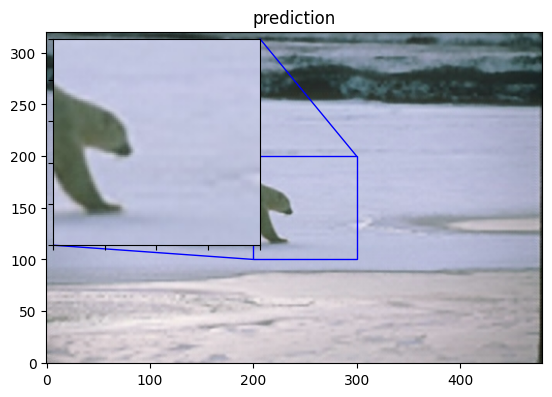

50/50 - 3s - 64ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 102/150
Mean PSNR for epoch: 26.78
50/50 - 2s - 40ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 103/150
Mean PSNR for epoch: 26.58
50/50 - 2s - 33ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 104/150
Mean PSNR for epoch: 26.57
50/50 - 3s - 67ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 105/150
Mean PSNR for epoch: 26.16
50/50 - 2s - 31ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 106/150
Mean PSNR for epoch: 27.01
50/50 - 2s - 31ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 107/150
Mean PSNR for epoch: 26.84
50/50 - 1s - 30ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 108/150
Mean PSNR for epoch: 26.73
50/50 - 3s - 51ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 109/150
Mean PSNR for epoch: 26.34
50/50 - 2s - 30ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 110/150
Mean PSNR for epoch: 27.02
50/50 - 4s - 73ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 111/150
Mean PSNR for epoch: 26.77
50/50 - 4s - 81ms/st

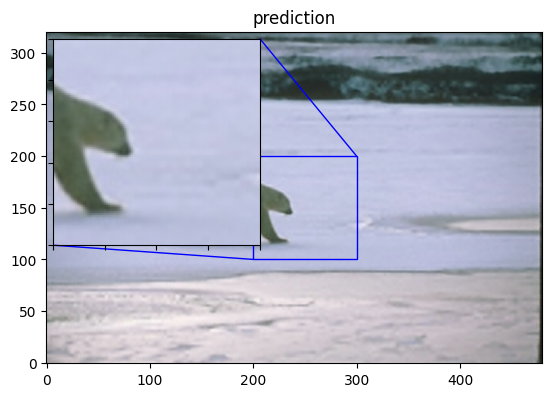

50/50 - 4s - 77ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 122/150
Mean PSNR for epoch: 26.85
50/50 - 4s - 77ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 123/150
Mean PSNR for epoch: 27.00
50/50 - 1s - 29ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 124/150
Mean PSNR for epoch: 26.37
50/50 - 3s - 52ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 125/150
Mean PSNR for epoch: 26.80
50/50 - 2s - 50ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 126/150
Mean PSNR for epoch: 26.46
50/50 - 2s - 39ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 127/150
Mean PSNR for epoch: 26.49
50/50 - 3s - 66ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 128/150
Mean PSNR for epoch: 27.42
50/50 - 2s - 31ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 129/150
Mean PSNR for epoch: 26.76
50/50 - 1s - 29ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 130/150
Mean PSNR for epoch: 26.96
50/50 - 3s - 51ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 131/150
Mean PSNR for epoch: 26.49
50/50 - 1s - 29ms/st

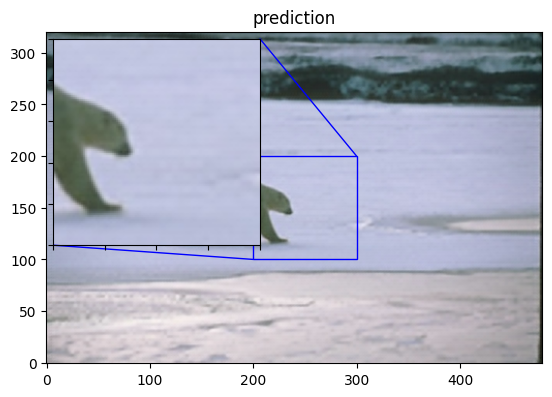

50/50 - 3s - 68ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 142/150
Mean PSNR for epoch: 26.78
50/50 - 3s - 55ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 143/150
Mean PSNR for epoch: 26.98
50/50 - 3s - 61ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 144/150
Mean PSNR for epoch: 26.96
50/50 - 4s - 72ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 145/150
Mean PSNR for epoch: 26.95
50/50 - 1s - 29ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 146/150
Mean PSNR for epoch: 26.80
50/50 - 1s - 29ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 147/150
Mean PSNR for epoch: 26.56
50/50 - 3s - 51ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 148/150
Mean PSNR for epoch: 26.63
50/50 - 3s - 59ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 149/150
Mean PSNR for epoch: 26.93
50/50 - 3s - 50ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 150/150
Mean PSNR for epoch: 26.95
50/50 - 2s - 36ms/step - loss: 0.0024 - val_loss: 0.0022


In [ ]:
epochs = 150

model.compile(
    optimizer=optimizer, loss=loss_fn,
)

model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=valid_ds, verbose=2
)

# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_filepath)

In [31]:
# Tạo thư mục Models và thư mục con image_upscale_model
%cd ../
!mkdir Models
!mkdir Models/image_upscale_model

# Lưu model vào thư mục Models/image_upscale_model
model_save_path = 'Models/image_upscale_model/my_model.keras'
model.save(model_save_path)

/content/gdrive/MyDrive


## Chạy mô hình:

In [ ]:
# Load the saved model
model_path = 'Models/image_upscale_model/my_model.keras'
model = keras.models.load_model(model_path, custom_objects={"DepthToSpaceLayer": DepthToSpaceLayer})

In [28]:
# Tạo thư mục prediction để lưu các dự đoán của model
!mkdir predictions
%cd predictions

/content/gdrive/MyDrive/Group-Project---Image-Upscaling/predictions


/content/gdrive/MyDrive/Group-Project---Image-Upscaling/predictions
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
PSNR of low resolution image and high resolution image is 26.7388
PSNR of predict and high resolution is 27.3874


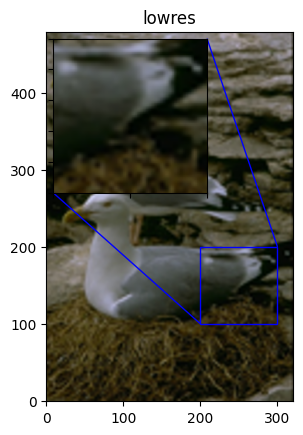

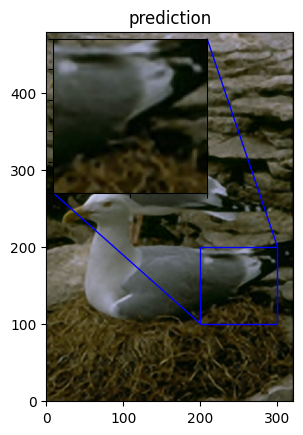

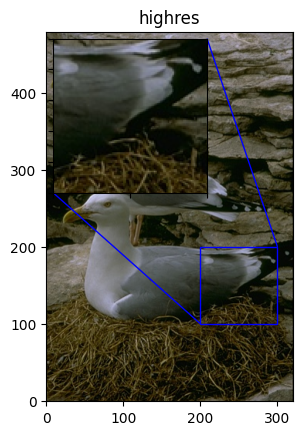

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
PSNR of low resolution image and high resolution image is 30.5025
PSNR of predict and high resolution is 30.8693


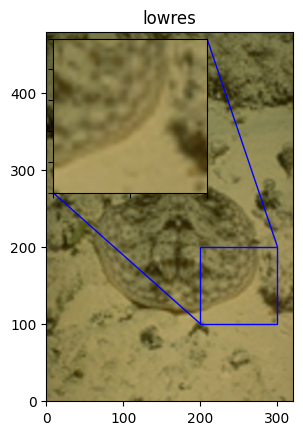

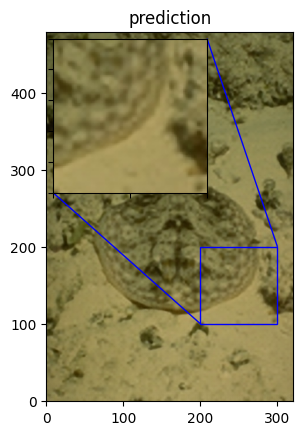

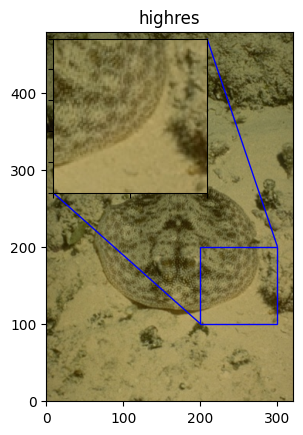

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step
PSNR of low resolution image and high resolution image is 31.3034
PSNR of predict and high resolution is 31.7763


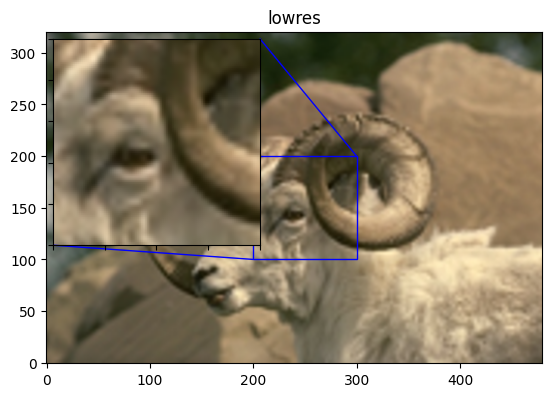

KeyboardInterrupt: 

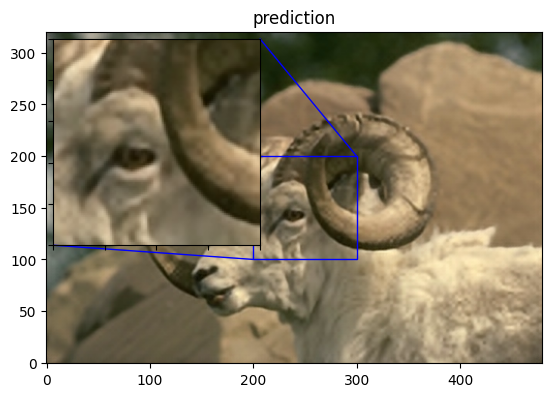

In [38]:
total_bicubic_psnr = 0.0
total_test_psnr = 0.0

for index, test_img_path in enumerate(test_img_paths[50:60]):
    img = load_img(test_img_path)
    lowres_input = get_lowres_image(img, upscale_factor)

    w = lowres_input.size[0] * upscale_factor
    h = lowres_input.size[1] * upscale_factor

    prediction = upscale_image(model, lowres_input)

    lowres_img = lowres_input.resize((w, h))
    lowres_img_arr = img_to_array(lowres_img)
    highres_img = img.resize((w, h))
    highres_img_arr = img_to_array(highres_img)
    predict_img_arr = img_to_array(prediction)

    bicubic_psnr = tf.image.psnr(lowres_img_arr, highres_img_arr, max_val=255)
    test_psnr = tf.image.psnr(predict_img_arr, highres_img_arr, max_val=255)

    total_bicubic_psnr += bicubic_psnr
    total_test_psnr += test_psnr

    print("PSNR of low resolution image and high resolution image is %.4f" % bicubic_psnr)
    print("PSNR of predict and high resolution is %.4f" % test_psnr)

    # Lưu ảnh trực tiếp trong thư mục hiện tại
    lowres_output_path = f"lowres_{index}.png"
    highres_output_path = f"highres_{index}.png"
    prediction_output_path = f"prediction_{index}.png"

    lowres_img.save(lowres_output_path)
    highres_img.save(highres_output_path)
    prediction.save(prediction_output_path)


    plot_results(lowres_img, index, "lowres")
    plot_results(prediction, index, "prediction")
    plot_results(highres_img, index, "highres")


print("Avg. PSNR of lowres images is %.4f" % (total_bicubic_psnr / 10))
print("Avg. PSNR of reconstructions is %.4f" % (total_test_psnr / 10))


## Chạy app.py để triển khai web:

In [39]:
%cd /content/gdrive/MyDrive/Group-Project---Image-Upscaling

/content/gdrive/MyDrive/Group-Project---Image-Upscaling


In [40]:
from google.colab import output
output.serve_kernel_port_as_window(5000)

Try `serve_kernel_port_as_iframe` instead. 


<IPython.core.display.Javascript object>

In [41]:
!python app.py

2024-12-11 14:56:29.546798: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-11 14:56:29.604294: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-11 14:56:29.618812: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-11 14:56:31.587215: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
 * Serving Flask app 'app'
 * Debug mode: on
 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with stat
2024-12-11 14:56:34.259656: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT